Obteniendo datos para aapl desde https://www.marketwatch.com/investing/stock/aapl/download-data?mod=mw_quote_tab
Rendimientos para aapl calculados correctamente.
Obteniendo datos para orcl desde https://www.marketwatch.com/investing/stock/orcl/download-data?mod=mw_quote_tab
Rendimientos para orcl calculados correctamente.
Obteniendo datos para pfe desde https://www.marketwatch.com/investing/stock/pfe/download-data?mod=mw_quote_tab
Rendimientos para pfe calculados correctamente.
Obteniendo datos para aapl desde https://www.marketwatch.com/investing/stock/aapl/download-data?mod=mw_quote_tab
Rendimientos para aapl calculados correctamente.
Obteniendo datos para orcl desde https://www.marketwatch.com/investing/stock/orcl/download-data?mod=mw_quote_tab
Rendimientos para orcl calculados correctamente.
Obteniendo datos para pfe desde https://www.marketwatch.com/investing/stock/pfe/download-data?mod=mw_quote_tab
Rendimientos para pfe calculados correctamente.
Tabla de Covarianza para ID 1:
   

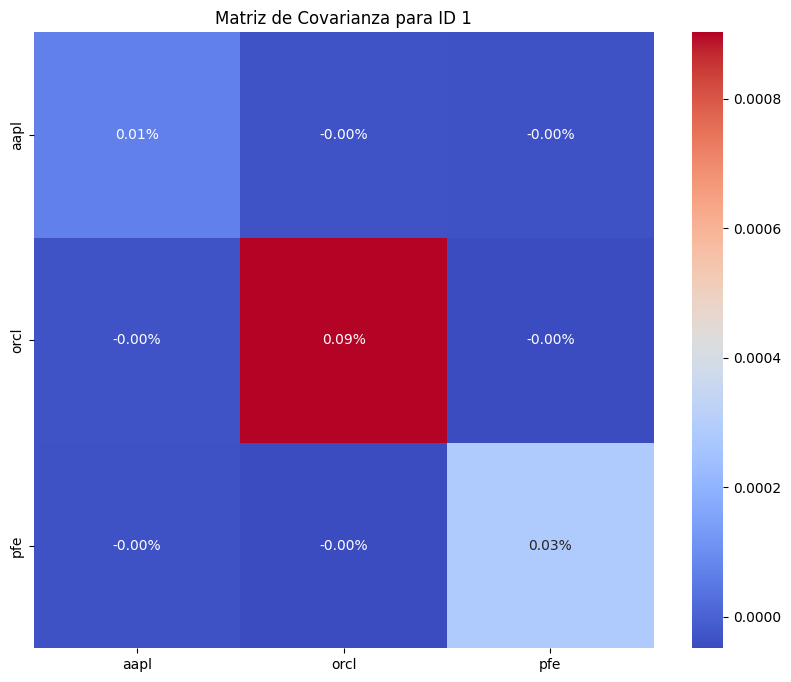

Tabla de Covarianza para ID 2:
          aapl      orcl       pfe
aapl  0.000068 -0.000031 -0.000036
orcl -0.000031  0.000903 -0.000049
pfe  -0.000036 -0.000049  0.000282




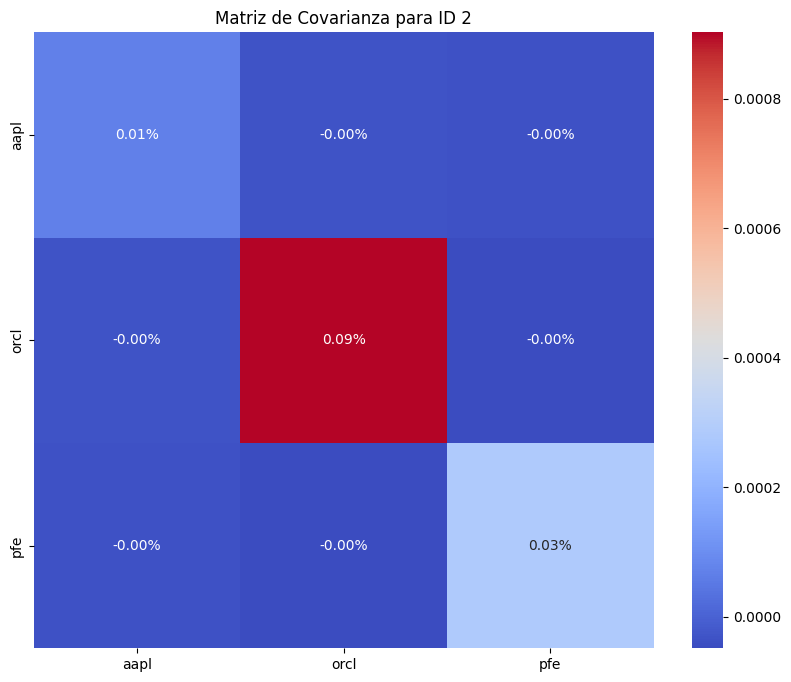

Estadísticas para ID 1:
                        aapl      orcl       pfe
Media               0.002037 -0.006943 -0.001101
Varianza            0.000068  0.000903  0.000282
DesviacionEstandar  0.008255  0.030045  0.016804




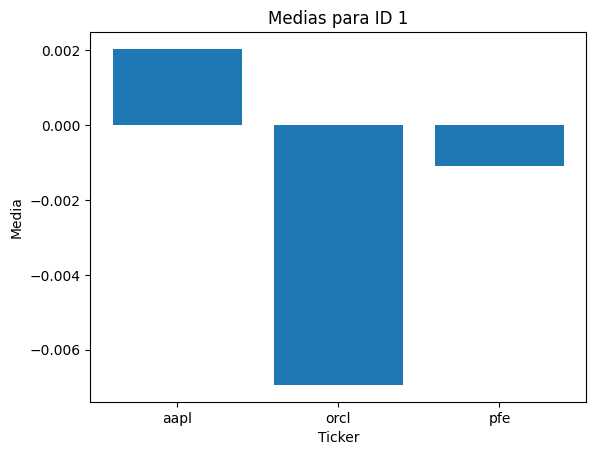

Estadísticas para ID 2:
                        aapl      orcl       pfe
Media               0.002037 -0.006943 -0.001101
Varianza            0.000068  0.000903  0.000282
DesviacionEstandar  0.008255  0.030045  0.016804




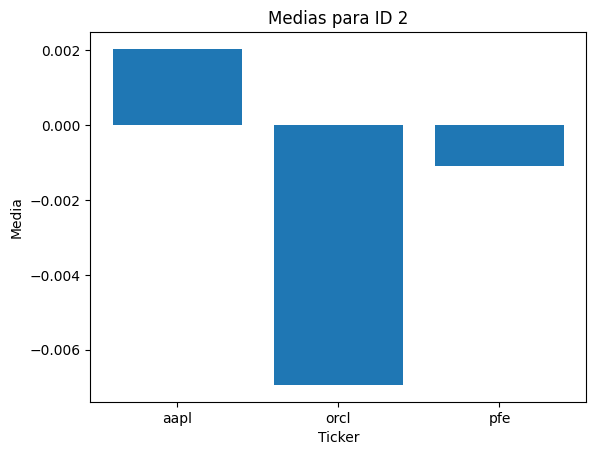

Resultados de la optimización para ID 1:
Pesos Optimizados: [1.00000000e+00 1.17267307e-15 0.00000000e+00]
Rendimiento Optimizado: 0.0020369561960087066




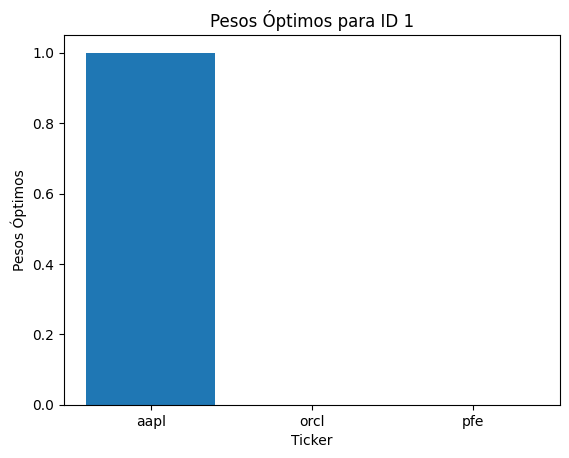

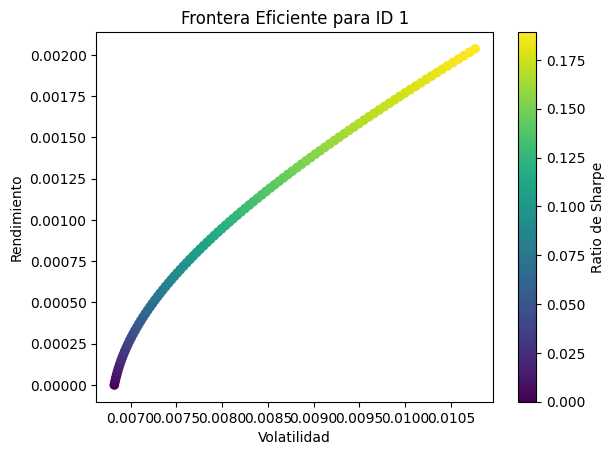

Resultados de la optimización para ID 2:
Pesos Optimizados: [1.00000000e+00 1.17267307e-15 0.00000000e+00]
Rendimiento Optimizado: 0.0020369561960087066




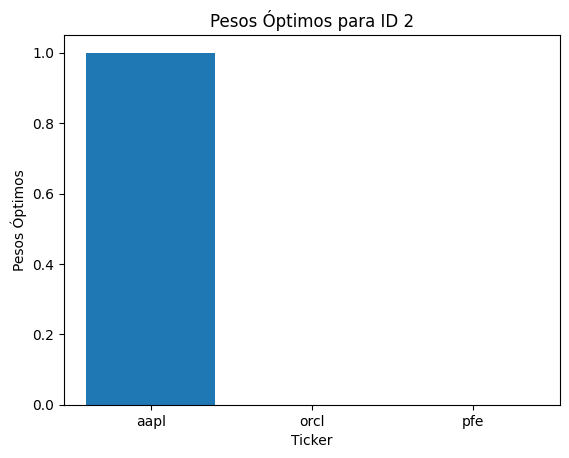

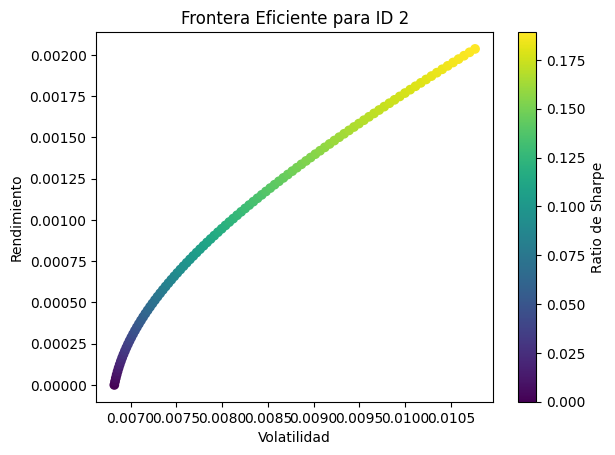

In [26]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup
from scipy.optimize import minimize
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings('ignore')

# Conecta con la base de datos SQLite
conn = sqlite3.connect('api.sqlite')
cursor = conn.cursor()

# Supongamos que tienes una tabla llamada 'tus_datos' y la columna de tickers se llama 'Ticker'
tabla = 'Tickers'
columna_ticker = 'tickers'
columna_id = 'id'

# Obtén los registros desde la base de datos
query = f"SELECT {columna_ticker}, {columna_id} FROM {tabla}"
df = pd.read_sql_query(query, conn)

# Convierte los valores separados por comas en listas
df[columna_ticker] = df[columna_ticker].str.split(',')

# Cierra la conexión con la base de datos
conn.close()

# Diccionario para almacenar los resultados
resultados_por_id = {}
covarianza_por_id = {}
estadisticas_por_id = {}
optimizacion_por_id = {}

for idx, group in df.groupby(columna_id):
    resultado_df = pd.DataFrame()

    for tickers_lista in group[columna_ticker]:
        for ticker in tickers_lista:
            # Elimina espacios de los tickers
            ticker = ticker.strip()

            url = f'https://www.marketwatch.com/investing/stock/{ticker}/download-data?mod=mw_quote_tab'
            print(f"Obteniendo datos para {ticker} desde {url}")

            pagina = requests.get(url)

            # Selecciona la tabla con la clase específica
            sopa = BeautifulSoup(pagina.text, 'html.parser')
            tabla = sopa.find('div', class_="download-data")

            # Asegúrate de que la tabla fue encontrada antes de intentar leerla
            if tabla:
                df_ticker = pd.read_html(str(tabla))[0]

                # Elimina los símbolos de pesos de la columna 'Close' y conviértela a tipo numérico
                df_ticker['Close'] = pd.to_numeric(df_ticker['Close'].str.replace('[$,]', '', regex=True), errors='coerce')

                # Calcula los rendimientos con la nueva fórmula
                df_ticker['Rendimiento'] = (df_ticker['Close'].shift(1) - df_ticker['Close']) / df_ticker['Close']

                # Agrega los rendimientos al DataFrame final por ID
                resultado_df[ticker] = df_ticker['Rendimiento']

                print(f"Rendimientos para {ticker} calculados correctamente.")
            else:
                print(f"No se encontró la tabla con la clase especificada para {ticker}.")

    # Calcula la covarianza entre los tickers y almacénala en el diccionario
    covarianza = resultado_df.cov()
    covarianza_por_id[idx] = covarianza

    # Calcula las estadísticas para cada ticker y almacénalas en el diccionario
    estadisticas = pd.DataFrame({
        'Media': resultado_df.mean(),
        'Varianza': resultado_df.var(),
        'DesviacionEstandar': resultado_df.std()
    })
    estadisticas_por_id[idx] = estadisticas.T  # Transponer el DataFrame

    # Agrega este DataFrame al diccionario
    resultados_por_id[idx] = resultado_df

    # Optimización de la cartera
    rendimientos = estadisticas['Media'].values
    covarianza_matrix = covarianza.values

    # Función objetivo a maximizar (rendimiento esperado)
    def objetivo(x):
        rendimiento_esperado = -np.dot(rendimientos, x)
        return rendimiento_esperado

    # Restricciones
    restricciones = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Suma de porcentajes igual a 100%
                     {'type': 'ineq', 'fun': lambda x: x},  # Porcentajes no negativos
                     {'type': 'ineq', 'fun': lambda x: 1 - x})  # Porcentajes no mayores a 100%

    # Límites de porcentajes (entre 0% y 100%)
    limites = tuple((0, 1) for _ in rendimientos)

    # Inicialización de pesos (podrías ajustar esto)
    pesos_iniciales = np.ones(len(rendimientos)) / len(rendimientos)

    # Resuelve el problema de optimización
    resultado_optimizacion = minimize(objetivo, pesos_iniciales, method='SLSQP', bounds=limites, constraints=restricciones)

    # Almacena los resultados de la optimización
    optimizacion_por_id[idx] = {
        'PesosOptimizados': resultado_optimizacion.x,
        'RendimientoOptimizado': -resultado_optimizacion.fun
    }

# Muestra las tablas de covarianza
for idx, covarianza_df in covarianza_por_id.items():
    print(f"Tabla de Covarianza para ID {idx}:")
    print(covarianza_df)
    print("\n")

    # Gráfico de Heatmap para Covarianza
    plt.figure(figsize=(10, 8))
    sns.heatmap(covarianza_df, annot=True, cmap='coolwarm', fmt='.2%')
    plt.title(f'Matriz de Covarianza para ID {idx}')
    plt.show()

# Muestra las estadísticas
for idx, estadisticas_df in estadisticas_por_id.items():
    print(f"Estadísticas para ID {idx}:")
    print(estadisticas_df)
    print("\n")
    # Gráfico de Barras para Medias
    plt.bar(estadisticas_df.columns, estadisticas_df.loc['Media'])
    plt.title(f'Medias para ID {idx}')
    plt.xlabel('Ticker')
    plt.ylabel('Media')
    plt.show()

# Muestra los resultados de la optimización
for idx, resultado_optimizacion in optimizacion_por_id.items():
    print(f"Resultados de la optimización para ID {idx}:")
    print("Pesos Optimizados:", resultado_optimizacion['PesosOptimizados'])
    print("Rendimiento Optimizado:", resultado_optimizacion['RendimientoOptimizado'])
    print("\n")
    # Gráfico de Barras para Pesos Óptimos
    plt.bar(estadisticas_por_id[idx].columns, resultado_optimizacion['PesosOptimizados'])
    plt.title(f'Pesos Óptimos para ID {idx}')
    plt.xlabel('Ticker')
    plt.ylabel('Pesos Óptimos')
    plt.show()

    # Gráfico de Frontera Eficiente
    # Calcula la frontera eficiente
    rendimientos_eficientes = np.linspace(0, max(estadisticas_por_id[idx].loc['Media']), num=100)
    volatilidades_eficientes = []

    for rendimiento_eficiente in rendimientos_eficientes:
        # Restricciones
        restricciones_eficientes = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                                     {'type': 'ineq', 'fun': lambda x: x},
                                     {'type': 'ineq', 'fun': lambda x: 1 - x},
                                     {'type': 'eq', 'fun': lambda x: np.dot(rendimientos, x) + rendimiento_eficiente})

        # Resuelve el problema de optimización
        resultado_eficiente = minimize(objetivo, pesos_iniciales, method='SLSQP', bounds=limites, constraints=restricciones_eficientes)

        # Calcula la volatilidad para este rendimiento eficiente
        volatilidad_eficiente = np.sqrt(np.dot(np.dot(resultado_eficiente.x, covarianza_matrix), resultado_eficiente.x))
        volatilidades_eficientes.append(volatilidad_eficiente)

    # Gráfico de Frontera Eficiente
    plt.scatter(volatilidades_eficientes, rendimientos_eficientes, c=rendimientos_eficientes/volatilidades_eficientes, cmap='viridis')
    plt.colorbar(label='Ratio de Sharpe')
    plt.title(f'Frontera Eficiente para ID {idx}')
    plt.xlabel('Volatilidad')
    plt.ylabel('Rendimiento')
    plt.show()
